### **Action** 
* **Import essential tools and set up OpenAI's API environment.** 
* **Load Nestle's HR policy using PyPDFLoader and split it for easy processing.** 
* **Create vector representations for text chunks using Chroma dB and OpenAI's embeddings.** 
* **Build a question-answering system using the GPT-3.5 Turbo model to retrieve answers from text chunks.** 
* **Create a prompt template to guide the chatbot in understanding and responding to users.** 
* **Use Gradio to build a user-friendly chatbot interface, enabling interaction and information retrieval.** 

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [4]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Step 1) Loading the pdf data into a doc object
docs = PyPDFLoader('the_nestle_hr_policy_pdf_2012.pdf').load()

In [6]:
#Step 2) Splitting the document into chunks for easier processing

splitter = RecursiveCharacterTextSplitter(chunk_size=350, chunk_overlap=55)
chunks = splitter.split_documents(docs)
print(f"For Document - {docs[0].metadata['source']}")
print(f"Chunks: {len(chunks)}")
for i, c in enumerate(chunks):
    print(f"Chunk {i+1}: {c.page_content}")

For Document - the_nestle_hr_policy_pdf_2012.pdf
Chunks: 54
Chunk 1: Policy
Mandatory
September   2012
The Nestlé  
Human Resources Policy
Chunk 2: Policy
Mandatory
September 
 20
12
Issuing  departement
Hum
an Resources
T arget  audience  
All
 employees
Approver
Executive Board, Nestlé S.A.
Repository
All Nestlé Principles and Policies, Standards and  
Guidelines can be found in the Centre online repository at:  
http://intranet.nestle.com/nestledocs
Copyright
 and  confidentiality
Al
Chunk 3: Copyright
 and  confidentiality
Al
l rights belong to Nestec Ltd., Vevey, Switzerland.
© 2012, Nestec Ltd.
Design
Nestec Ltd., Corporate Identity & Design,  
Vevey, Switzerland
Production
brain’print GmbH, Switzerland
Paper
This report is printed on BVS, a paper produced  
from well-managed forests and other controlled sources
Chunk 4: certified by the Forest Stewardship Council (FSC).
Chunk 5: The Nestlé Human Resources Policy
1
At Nestlé, we recognize that our employees 
are the key to our su

In [7]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [9]:
#Step3) Generating vector representation out of vector DB from the chunks
vector_doc = FAISS.from_documents(chunks, embeddings)

In [10]:
#shape of the vector
num_vectors = vector_doc.index.ntotal
dimensions = vector_doc.index.d

print(f"Shape: ({num_vectors}, {dimensions})")

Shape: (54, 1536)


In [12]:
#Step4) Gnerating the retriever out of the vector store
retriever = vector_doc.as_retriever(search_kwargs={"k" : 5})

In [13]:
from langchain_openai import ChatOpenAI
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import PromptTemplate

In [32]:
#step5) passing the docs into the LLM and creating the rag-chain based on a prompt-template.
prompt_template = """You are a HR Assistant for Nestle. You should answer any queries related to Nestle's HR Reports in a user-friendly and accurate way.

Refer to the data - {context} and answer only based on this data.Anything else should be responded with 'This is an out of context question/query, please ask relevant HR questions and I will be happy to help :) .'

Question: {input}
Answer here:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "input"]
)


llm = ChatOpenAI(model="gpt-3.5-turbo")

combine_docs_chain = create_stuff_documents_chain(llm, PROMPT) # PROMPT | llm

qa = create_retrieval_chain(
    retriever=retriever,
    combine_docs_chain=combine_docs_chain
)

In [34]:
#testing phase:( in context )
result = qa.invoke({"input": "Could you give me a 3 sentence overview of the Nestle HR report?"})

print(result['input'])
print(result['answer'])

Could you give me a 3 sentence overview of the Nestle HR report?
The Nestlé Human Resources Policy emphasizes the importance of employee engagement and outlines guidelines for effective HR management globally. It highlights Nestlé's values of trust, mutual respect, and dialogue, and the role of HR in optimizing employee performance and creating exemplary working conditions. Line managers are responsible for fostering a work environment where employees are personally committed and can contribute to the company's success.


In [35]:
#testing phase:(out of context query)
result = qa.invoke({"input": "Why does Earth rotate with contant speed?"})

print(result['input'])
print(result['answer'])

#the result shows that the assistant replies only based on the context provided to it using the retriever object.

Why does Earth rotate with contant speed?
This is an out of context question/query, please ask relevant HR questions and I will be happy to help :) .


In [36]:
#testing phase:( in context )
result = qa.invoke({"input": "How is the company performing in terms of training?"})

print(result['input'])
print(result['answer'])

How is the company performing in terms of training?
The company places a strong emphasis on training and development as part of its culture. Employees are encouraged to continuously upgrade their knowledge and skills, and the company determines training priorities. Nestlé offers a comprehensive range of training activities and methodologies to support learning and growth. A high performance culture supported by differentiated rewards and development is key to meeting individual and business objectives. Training is seen as a crucial component of ongoing development, rather than just a reward. Leadership programmes are also in place to ensure the continued development of people and the company.


In [ ]:
#Step6)Use Gradio to build a user-friendly chatbot interface, enabling interaction and information retrieval. 

In [25]:
import gradio as gr

c:\Users\Siddhartha\miniconda3\envs\langchainenvjan31\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
def nestle_hr_bot(query: str):
    result = qa.invoke({'input':query})
    return f"Question: {result['input']} \nAnswer: {result['answer']}"

In [38]:
demo = gr.Interface(
    fn=nestle_hr_bot, 
    inputs=["text"], 
    outputs=["text"]
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


![Screenshot 2026-02-01 120900.png](<attachment:Screenshot 2026-02-01 120900.png>)
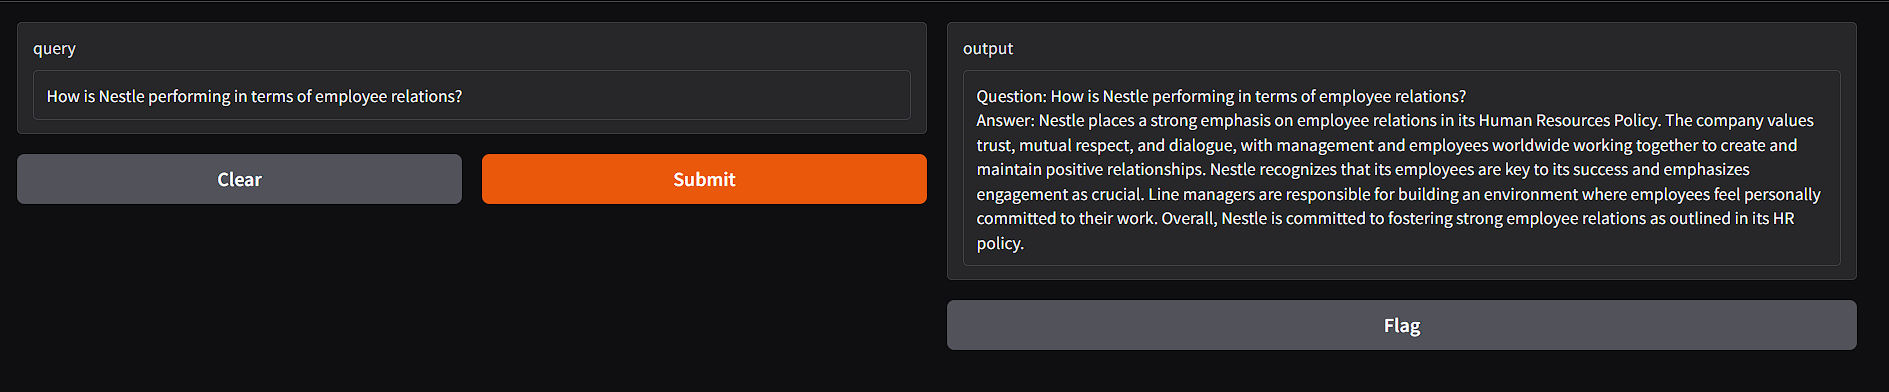

![Screenshot 2026-02-01 121243.png](<attachment:Screenshot 2026-02-01 121243.png>)
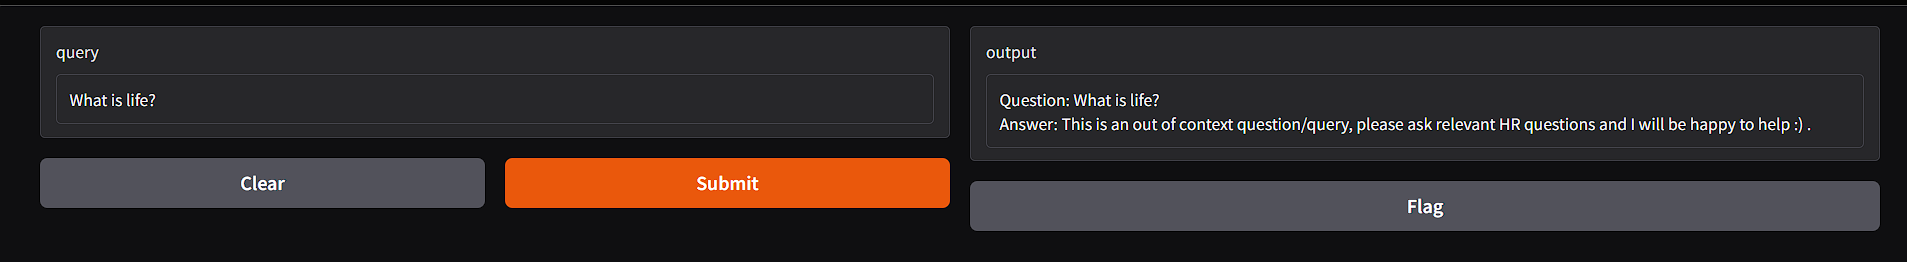